_**Note:** This notebook is intended solely as a demonstration of how to use the developed codebase. The outputs and results presented here are for illustrative purposes only and should not be considered accurate, validated, or representative of real-world performance. The focus of this notebook is on showcasing functionality, not on the correctness or significance of the results._

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
# import sys
# sys.path.append('../src/')  # path to root of code_base directory - Only if not installed as a package

from laneq.model_suite.dataloader import generate_dataloader

from laneq.model_suite import training 
from laneq.model_suite.training import get_loss, train_loop
from laneq.model_suite.architectures import get_model
from laneq.model_suite.evaluation_metrics import cal_classification_metrics

from laneq.model_suite.utils.inference_utils import generate_saliency_map, load_saved_model, pred_degradation_category
from laneq.model_suite.utils.common import load_config, visualize_confusion_matrix
from laneq.model_suite.utils.preprocessing import load_image

In [3]:
torch.cuda.empty_cache()

# Training

In [4]:
config_path = "../configs/classification.yaml"
config = load_config(config_path)
pprint(config)

{'data_loader': {'batch_size': 1, 'num_workers': 2, 'shuffle': True},
 'dataset_loc': {'dataset_type': 'classification',
                 'train': {'degradation_csv': '/cs6945share/retro_project/bdd100k/generated_segments/train.csv',
                           'img_dir': '/cs6945share/retro_project/bdd100k/images/train',
                           'random_subset': None},
                 'val': {'degradation_csv': '/cs6945share/retro_project/bdd100k/generated_segments/val.csv',
                         'img_dir': '/cs6945share/retro_project/bdd100k/images/val',
                         'random_subset': None}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 3},
 'results_loc': './experiment_results/',
 'training': {'learning_rate': 0.05,
              'loss_fn_name': 'CrossEntropy',
              'num_epochs': 10,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 5}}


In [26]:
# # copy paste above config here foro quick edit and experimentation
config={
  'data_loader': {
    'batch_size': 1,
    'num_workers': 2,
    'shuffle': True
  },
    
  'dataset_loc': {
    'dataset_type': 'classification',
    'train': {
      'degradation_csv': '/cs6945share/retro_project/classification_bdd100k/segments_v5/degradation_segment_labels_train.csv',
      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments_v5/train/',
      'random_subset': None
    },
    'val': {
      'degradation_csv': '/cs6945share/retro_project/classification_bdd100k/segments_v5/degradation_segment_labels_val.csv',
      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments_v5/val/',
      'random_subset': None
    }
  },
  'enable_cuda': True,
    
  'model': {
    'in_channels': 3,
    'out_dim': 3
  },
    
  'results_loc': '../experiment_results/',
    
  'training': {
    'learning_rate': 0.01,
    'loss_fn_name': 'CrossEntropy',
    'num_epochs': 10,
    'resume_checkpoint': None,
    'save_checkpoint_freq': 5
  }
}

In [27]:
# get required config parameters
model_config = config["model"]
dataset_config = config["dataset_loc"]
dataloader_config = config["data_loader"]
preprocess_config = config.get("dataset_preprocessing", None)
train_config = config["training"]

In [28]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE = training.DEVICE
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [29]:
# update img trasnform if required

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.ToTensor()                    # Convert the image to a tensor
])

# generate train data loader
train_loader, train_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                               data_loc=dataset_config["train"],
                                               dataloader_config=dataloader_config,
                                               preprocess_config=preprocess_config)

# generate validation data loader
val_loader, val_size = generate_dataloader(dataset_type=dataset_config["dataset_type"],
                                           data_loc=dataset_config["val"],
                                           dataloader_config=dataloader_config,
                                           preprocess_config=preprocess_config)

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 1235
Validation Dataset loaded. #samples: 253


Image batch shape: torch.Size([1, 3, 163, 396])
Degradation label shape: torch.Size([1, 3])
Degradation target: tensor([1., 0., 0.])


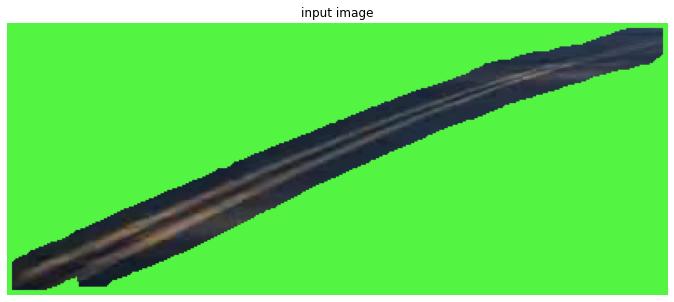

In [32]:
# Ensure that we are getting correct data from data loaders
batch_img, degradation_values = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("Degradation label shape:", degradation_values.shape) 
print("Degradation target:", degradation_values[0])

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

# sample_mask = batch_mask[0].numpy()   # (c, h, w)
# sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(sample_img)
ax.set_title("input image")
ax.axis("off")
plt.show()

In [33]:
# Initializing the model, loss function, and the optimizer
model_name = "cnn_sppf"
model = get_model(model_name, **model_config)
model = model.to(training.DEVICE)

## fetch loss function as set in config
criterion = get_loss(train_config["loss_fn_name"])

## OR add your own loss fucntion like shown below
# from model_suite.focal_loss import FocalLoss
# num_classes = 3
# alpha = [1.0, 1.2, 1.2]  # Example class weights
# criterion = FocalLoss(gamma=2, alpha=alpha, task_type='multi-class', num_classes=num_classes)

# initialized optimizer as required
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))
    print("Model checkpoint loaded.")

In [34]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"], save_prefix=model_name)

Training Started...


Epoch: 1 val - : 100%|██████████| 253/253 [00:00<00:00, 273.65it/s]


Epoch [1/10], Train Loss: 1.0472, Val Loss: 1.0551, Epoch execution time: 0.16 min


Epoch: 2 val - : 100%|██████████| 253/253 [00:00<00:00, 275.70it/s]


Epoch [2/10], Train Loss: 1.0346, Val Loss: 1.0750, Epoch execution time: 0.17 min


Epoch: 3 val - : 100%|██████████| 253/253 [00:00<00:00, 279.67it/s]


Epoch [3/10], Train Loss: 1.0344, Val Loss: 1.0852, Epoch execution time: 0.18 min


Epoch: 4 val - : 100%|██████████| 253/253 [00:00<00:00, 273.61it/s]


Epoch [4/10], Train Loss: 1.0344, Val Loss: 1.0786, Epoch execution time: 0.17 min


Epoch: 5 val - : 100%|██████████| 253/253 [00:00<00:00, 284.11it/s]


Epoch [5/10], Train Loss: 1.0353, Val Loss: 1.0610, Epoch execution time: 0.16 min


Epoch: 6 val - : 100%|██████████| 253/253 [00:00<00:00, 275.64it/s]


Epoch [6/10], Train Loss: 1.0339, Val Loss: 1.0772, Epoch execution time: 0.16 min


Epoch: 7 val - : 100%|██████████| 253/253 [00:00<00:00, 263.39it/s]


Epoch [7/10], Train Loss: 1.0350, Val Loss: 1.0794, Epoch execution time: 0.15 min


Epoch: 8 val - : 100%|██████████| 253/253 [00:00<00:00, 280.20it/s]


Epoch [8/10], Train Loss: 1.0356, Val Loss: 1.0797, Epoch execution time: 0.14 min


Epoch: 9 val - : 100%|██████████| 253/253 [00:00<00:00, 280.32it/s]


Epoch [9/10], Train Loss: 1.0348, Val Loss: 1.0869, Epoch execution time: 0.16 min


Epoch: 10 val - : 100%|██████████| 253/253 [00:00<00:00, 282.53it/s]


Epoch [10/10], Train Loss: 1.0364, Val Loss: 1.0759, Epoch execution time: 0.15 min
   Learning curve saved to ../experiment_results/train_log/learning_curve_2025-04-16_07-16-35.png
   Learning history saved to ../experiment_results/train_log/learning_history_2025-04-16_07-16-35.json
Model saved at: ../experiment_results/checkpoints/cnn_sppf_final_2025-04-16_07-16-35.pth
Training Completed! Total time: 1.6036 min


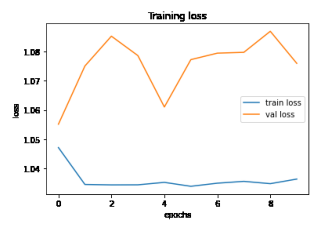

In [35]:
# open saved learning curve
plot_saved_path = "../experiment_results/train_log/learning_curve_2025-04-16_07-16-35.png"    # replace with required path
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [36]:
# Evaluate model performance at end of training using different losses
train_metrics, train_cm = cal_classification_metrics(model, train_loader, device=DEVICE)
val_metrics, val_cm = cal_classification_metrics(model, val_loader, device=DEVICE)

100%|██████████| 253/253 [00:00<00:00, 284.79it/s]


In [37]:
stats = pd.DataFrame([train_metrics, val_metrics], index=["train", "val"]).T
display(stats)

,train,val
accuracy,0.5012,0.4901
precision,0.2512,0.2402
recall,0.5012,0.4901
f1,0.3347,0.3224


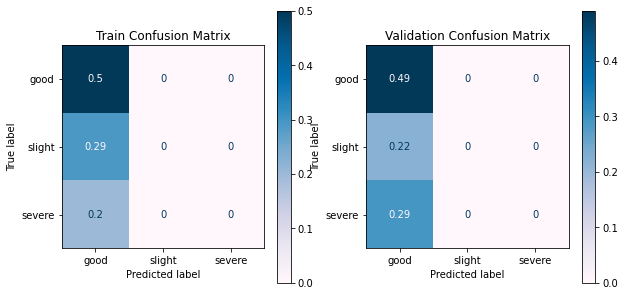

In [38]:
visualize_confusion_matrix(train_cm=train_cm, val_cm=val_cm, label_names=["good", "slight", "severe"])

## Saliency map

In [39]:
csv_path = dataset_config["val"]["degradation_csv"]
dir_path = dataset_config["val"]["img_dir"]
df = pd.read_csv(csv_path)
df.head(3)

,name,degradation_target
0,c9d61a6d-986df2e9_3.png,0
1,c9d61a6d-986df2e9_5.png,0
2,c9d61a6d-986df2e9_6.png,2


In [40]:
row = df.sample(1)
img_name, label = row["name"].values[0], row["degradation_target"].values[0]
p = os.path.join(dir_path, img_name)
img = load_image(p)

target class 2
Predicted Class 0


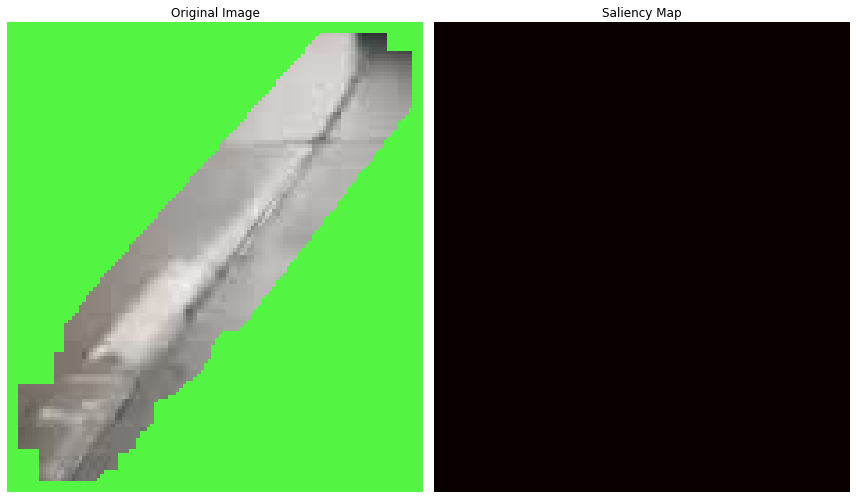

In [41]:
# Generate saliency map
print("target class", label)
saliency = generate_saliency_map(model, img, device=training.DEVICE)

# Plot the saliency map
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(img[:, :, :3])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the saliency map
axes[1].imshow(saliency, cmap='hot')
axes[1].set_title('Saliency Map')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Inference

In [42]:
# replace with requried path
saved_weight_path = "../experiment_results/checkpoints/cnn_sppf_final_2025-04-16_07-16-35.pth"

In [43]:
model_name = "cnn_sppf"
model_config = {'in_channels': 3, 'out_dim': 3}

In [44]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [45]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

In [46]:
csv_path = dataset_config["val"]["degradation_csv"]
dir_path = dataset_config["val"]["img_dir"]
df = pd.read_csv(csv_path)

row = df.sample(1)
test_img_name, label = row["name"].values[0], row["degradation_target"].values[0]
test_img_path = os.path.join(dir_path, test_img_name)
test_img = load_image(test_img_path)

Test image name: ca1543ec-6ad48f6e_7.png
Test image shape: (147, 224, 3)


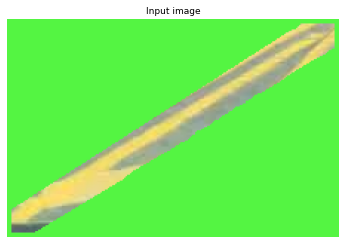

In [47]:
print("Test image name:", test_img_name)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [48]:
pred_class = pred_degradation_category(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
print("Predicticted degradation category:", pred_class)

Predicticted degradation category: 0
